## Exercises of day 5

A signal is recorded by a linear uniform array comprising 16 sensors located 5 cm apart with the following specifications: There are two narrowband sources impinging on the array which are sampled at 8 kHz. The first has a frequency of 500 Hz, an amplitude of 5, and a DOA of -pi/4. The second has a frequency of 500 Hz, an amplitude of 3, and a DOA of pi/5. 
- Compute the relative delays of the two sources for the different sensors.
- Write a script for testing DOA estimators based on the signal specified above assuming a complex signal model. Aside from the two signals specified above, also add complex Gaussian noise with a variance of 1 to the signal and generate 64 snapshots and compute the spatial covariance matrix.
- Implement the classic beamformer, i.e., the spatial equivalent of the periodogram, and plot the spatial spectrum.
- Implement Capon beamformer, plot the spatial spectrum and compare the result to the one obtained with the classic beamformer. 


In [1]:
#imports
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# parameters
N = 64 # Number of snapshots/signal length
M = 16 # Number of sensors
d = 0.05 # Distance between sensors
f = [500, 500] # Array containing frequencies
fs = 8000 # Sampling rate
doas = [-np.pi/4, np.pi/5] # Array containing DOAs
A = [5.0, 3.0] # Array containing amplitudes
phase = [0.3, 0.7] 

When we generate noise for the signal, we assume that the noise is unique for each sensor and as such we have a different signal for each sensor

In [3]:
class ArraySignal:
    def __init__(self, M, d):
        """
        Initialize the ArraySignal object.

        Parameters
        ----------
        M : int
            Number of sensors in the array.
        d : float
            Distance between adjacent sensors (in meters).
        """
        self.M = M
        self.d = d
        np.random.seed(42)

    def _steering_vectors(self, thetas, freqs, c=343.0):
        """
        Compute the steering vectors for the array.

        Parameters
        ----------
        thetas : array-like
            List or array of angles of arrival (in radians).
        freqs : array-like
            List or array of frequencies (in Hz).
        c : float, optional
            Speed of propagation (default is 343.0 m/s for air).

        Returns
        -------
        A : ndarray
            Steering matrix of shape (M, len(thetas)), complex-valued.
        """
        thetas = np.atleast_1d(thetas)
        freqs = np.atleast_1d(freqs)
        m_idx = np.arange(self.M) * self.d

        A = np.zeros((self.M, len(thetas)), dtype=complex)
        for i, (theta, f) in enumerate(zip(thetas, freqs)):
            k = 2 * np.pi * f / c
            phase_shifts = -1j * k * m_idx * np.sin(theta)
            A[:, i] = np.exp(phase_shifts)
        return A


    def generate_signal(self, N, fs, A, freqs, theta, sigma=1.0):

        n = np.arange(N)
        t = n / fs

  
        phases = np.random.uniform(0, 2*np.pi, size=len(A))
        S = np.zeros((len(A), N), dtype=complex)
        
        for i, (amp, f, phi) in enumerate(zip(A, freqs, phases)):
            S[i, :] = amp * np.exp(1j * (2*np.pi*f*t + phi))
 
        A_true = self._steering_vectors(theta, freqs)
        
        X_signal = A_true @ S
        noise = np.sqrt(sigma/2) * (np.random.randn(self.M, N) + 1j*np.random.randn(self.M, N))
        X = X_signal + noise
        return X

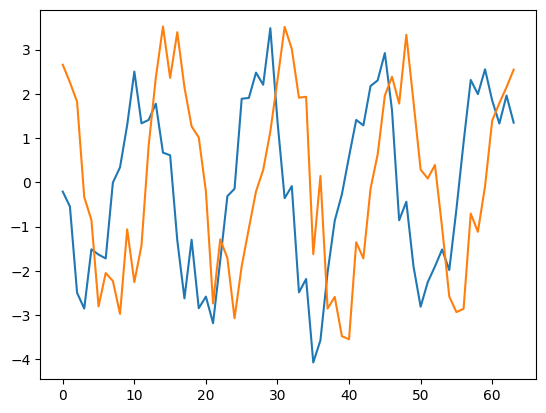

In [4]:
# Generate signal
signal_constructor = ArraySignal(M, d)
X = signal_constructor.generate_signal(N, fs, A, f, doas)

plt.plot(np.arange(X.shape[1]), X[0,:].real)
plt.plot(np.arange(X.shape[1]), X[0,:].imag)
plt.show()

Calculating the relative delays for each sesnor, assuming source at 0.

In [6]:
def get_delays(M, d:float, doas:list):
    '''
    Parameters:
        M: number of sensors
        d: sensor spacing
        doas (array): DOAs of sources
    '''
    doas = np.array(doas)
    c = 343.0
    m_idx = np.arange(M)
    positions = m_idx * d

    tau = np.zeros((positions.shape[0], doas.shape[0]))

    for i, doa in enumerate(doas):
        tau[:, i] = positions * np.sin(doa)  / c
   
    return tau

delays = get_delays(M, d, doas)
print(delays)

[[-0.00000000e+00  0.00000000e+00]
 [-1.03076790e-04  8.56829814e-05]
 [-2.06153581e-04  1.71365963e-04]
 [-3.09230371e-04  2.57048944e-04]
 [-4.12307161e-04  3.42731926e-04]
 [-5.15383951e-04  4.28414907e-04]
 [-6.18460742e-04  5.14097888e-04]
 [-7.21537532e-04  5.99780870e-04]
 [-8.24614322e-04  6.85463851e-04]
 [-9.27691112e-04  7.71146832e-04]
 [-1.03076790e-03  8.56829814e-04]
 [-1.13384469e-03  9.42512795e-04]
 [-1.23692148e-03  1.02819578e-03]
 [-1.33999827e-03  1.11387876e-03]
 [-1.44307506e-03  1.19956174e-03]
 [-1.54615185e-03  1.28524472e-03]]


Implementing beamformers

In [7]:
class CaponBeamformer:
    def __init__(self, x, M):
        self.x = x
        self.M = M

        self.R, self.R_inv = self._get_spatial_covariance()

    def _get_spatial_covariance(self):
        _, N = self.x.shape
        R = (1.0 / N) * (self.x @ self.x.conj().T)
        R_inv = np.linalg.inv(R + 1e-6 * np.eye(self.M))
        return R, R_inv

    def _steering_vectors(self, theta, d, f, c=343.0):
        thetas = np.atleast_1d(theta)
        freqs = np.atleast_1d(f)
        m_idx = np.arange(self.M) * d

        A = np.zeros((self.M, len(thetas)), dtype=complex)
        for i, (theta, f) in enumerate(zip(thetas, freqs)):
            k = 2 * np.pi * f / c
            phase_shifts = -1j * k * m_idx * np.sin(theta)
            A[:, i] = np.exp(phase_shifts)
        return A

    def _get_grid(self, d, f, c=343):
        angles_deg = np.linspace(-90, 90, 721)
        angles_rad = np.deg2rad(angles_deg)

        A_grid = self._steering_vectors(angles_rad, d, np.full_like(angles_rad, np.mean(f)))

        return A_grid, angles_deg, angles_rad

    def compute_spectrum(self, d, f):
        A_grid, angles_deg, angles_rad = self._get_grid(d, f)

        P_capon = np.zeros(len(angles_rad))
        for i in range(len(angles_rad)):
            a = A_grid[:, i].reshape(self.M,1)
            denom = np.real((a.conj().T @ self.R_inv @ a)[0,0])
            P_capon[i] = 1.0 / denom
        return P_capon


class ClassicBeamformer:
    def __init__(self, x, M):
        self.x = x
        self.M = M

        self.R, self.R_inv = self._get_spatial_covariance()

    def _get_spatial_covariance(self):
        _, N = self.x.shape
        R = (1.0 / N) * (self.x @ self.x.conj().T)
        R_inv = np.linalg.inv(R + 1e-6 * np.eye(self.M))
        return R, R_inv

    def _steering_vectors(self, theta, d, f, c=343.0):
        thetas = np.atleast_1d(theta)
        freqs = np.atleast_1d(f)
        m_idx = np.arange(self.M) * d

        A = np.zeros((self.M, len(thetas)), dtype=complex)
        for i, (theta, f) in enumerate(zip(thetas, freqs)):
            k = 2 * np.pi * f / c
            phase_shifts = -1j * k * m_idx * np.sin(theta)
            A[:, i] = np.exp(phase_shifts)
        return A

    def _get_grid(self, d, f, c=343):
        angles_deg = np.linspace(-90, 90, 721)
        angles_rad = np.deg2rad(angles_deg)

        A_grid = self._steering_vectors(angles_rad, d, np.full_like(angles_rad, np.mean(f)))

        return A_grid, angles_deg, angles_rad

    def compute_spectrum(self, d, f):
        A_grid, angles_deg, angles_rad = self._get_grid(d, f)

        P_classic = np.zeros(len(angles_rad))
        for i in range(len(angles_rad)):
            a = A_grid[:, i].reshape(self.M,1)
            P_classic[i] = np.real((a.conj().T @ self.R @ a)[0,0])
        P_classic /= (self.M ** 2)

        return P_classic

In [9]:
beamformer_model = ClassicBeamformer(X, M)
P_classic = beamformer_model.compute_spectrum(d, f)

beamformer_model = CaponBeamformer(X, M)
P_capon = beamformer_model.compute_spectrum(d, f)

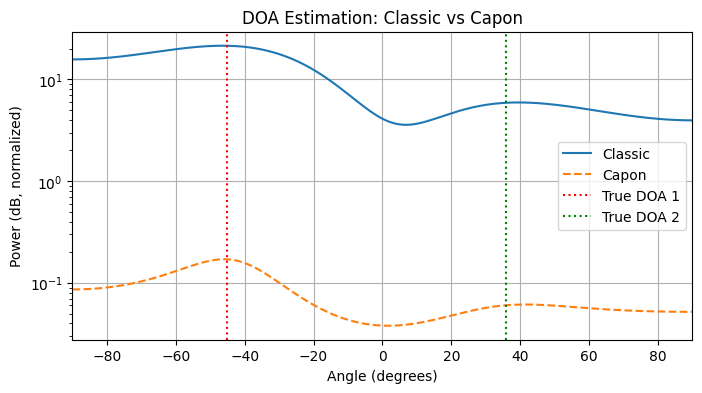

In [10]:
angles_deg = np.linspace(-90, 90, 721)

plt.figure(figsize=(8,4))
plt.plot(angles_deg, P_classic, label="Classic")
plt.plot(angles_deg, P_capon, label="Capon", linestyle="--")
plt.title("DOA Estimation: Classic vs Capon")
plt.xlabel("Angle (degrees)")
plt.ylabel("Power (dB, normalized)")
plt.legend()
plt.grid(True)
plt.xlim(-90, 90)
plt.yscale('log')

# Add true DOA vertical lines
plt.axvline(np.degrees(doas[0]), color='r', linestyle=':', label='True DOA 1')
plt.axvline(np.degrees(doas[1]), color='g', linestyle=':', label='True DOA 2')
plt.legend()
plt.show()